In [1]:
from pyspark.sql import SparkSession
from h2o.estimators import *
from pysparkling import *
import h2o
import shutil
from tqdm.notebook import tqdm
spark = SparkSession.builder.config('spark.dynamicAllocation.enabled','false').getOrCreate()

## Create H2O Sparkling Water cluster

In [2]:
conf = H2OConf().setInternalClusterMode()
hc = H2OContext.getOrCreate(conf)

Connecting to H2O server at http://10.128.98.41:54321 ... successful.


H2O_cluster_uptime:,10 secs
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,8 days
H2O_cluster_name:,sparkling-water-jovyan_spark-application-1606341750786
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.833 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.32.0.2-1-3.0
 * H2O name: jovyan
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,10.128.98.103,54321)
  ------------------------

  Open H2O Flow in browser: http://10.128.98.41:54321 (CMD + click in Mac OSX)

    


In [4]:
from splicemachine.spark.context import PySpliceContext
splice = PySpliceContext(spark)
from splicemachine.mlflow_support import *
from splicemachine.mlflow_support.utilities import get_user
mlflow.register_splice_context(splice)
mlflow.set_experiment('h2o deployment')
schema = get_user()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [4]:
from beakerx.object import beakerx

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## GBM

In [6]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator


# Import the titanic dataset into H2O:
titanic = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/titanic.csv")

# Set the predictors and response; set the response as a factor:
titanic["survived"] = titanic["survived"].asfactor()
predictors = ['sibsp', 'sex', 'age']
response = "survived"

# Split the dataset into a train and valid set:
train, valid = titanic.split_frame(ratios=[.8], seed=1234)


model = H2OGradientBoostingEstimator(ntrees         =50,
                                        max_depth      =6,
                                        learn_rate     =0.1, 
                                        nfolds         =2)

model.train(x               =predictors,
               y               =response,
               training_frame  =train,
               validation_frame=valid
               )


print('deploying gbm')
splice.dropTableIfExists(f'{schema}.h2o_gbm')

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_gbm',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
deploying gbm
Saving artifact of size: 70.231 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
---Job Logs---
INFO     2020-11-25 21:22:41.000 - A service worker has found your request
INFO     2020-11-25 21:22:41.063 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:22:41.096 - Handler is available
INFO     2020-11-25 21:22:41.117 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:22:41.183 - Retrieved MLFlow Run
INFO     2020-11-25 21:22:41.205 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:22:41.273 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:22:41.296 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:22:41.329 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:22:41.355 - Decompr

In [7]:
%%sql

insert into h2o_gbm (moment_key,sibsp,sex,age) values(0, 5,'female',2.496);
insert into h2o_gbm (moment_key,sibsp,sex,age) values(1, 1,'male',-7.048);
select * from h2o_gbm;
select sibsp, sex, age, prediction, c0, c1 into ${data_and_preds} from h2o_gbm;


Sql started successfully



In [8]:
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['SIBSP','SEX','AGE']])
db_preds = data[['PREDICTION','C0','C1']]
features.columns = [i.lower() for i in features.columns]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)



for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    db_p, db_c0, db_c1 = db_pred[1]
    raw_p, raw_c0, raw_c1 = raw_pred[1]
    # Table returns string but h2o returns int index
    raw_p = f'C{int(raw_p)}'
    
    assert db_p == raw_p, f'Something is wrong. Model Table gives {db_p} but raw model gives {raw_p}'
    assert round(db_c0,14) == round(raw_c0,14), f'Something is wrong. Model Table gives {db_c0} but raw model gives {raw_c0}'
    assert round(db_c1,14) == round(raw_c1,14), f'Something is wrong. Model Table gives {db_c1} but raw model gives {raw_c1}'

print('test passed!')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
test passed!


## Multinomial Model Example

In [9]:
cars = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/junit/cars_20mpg.csv")
cars["cylinders"] = cars["cylinders"].asfactor()
r = cars[0].runif()
train = cars[r > .2]
valid = cars[r <= .2]
response_col = "cylinders"
distribution = "multinomial"
predictors = ["displacement","power","weight","acceleration","year_make"]

train.rename(columns={'year':'year_make'})

model = H2OGradientBoostingEstimator(nfolds=3,
                                   distribution=distribution)
model.train(x=predictors,
          y=response_col,
          training_frame=train,
          validation_frame=valid)



print('deploying multinomial')
splice.dropTableIfExists(f'{schema}.h2o_multinomial')

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_multinomial',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
deploying multinomial
Saving artifact of size: 110.721 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:23:00.995 - A service worker has found your request
INFO     2020-11-25 21:23:01.039 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:23:01.074 - Handler is available
INFO     2020-11-25 21:23:01.099 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:23:01.165 - Retrieved MLFlow Run
INFO     2020-11-25 21:23:01.188 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:23:01.242 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:23:01.266 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:23:01.300 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:23:01.332 - Decompressing Model Ar

In [10]:
%%sql

insert into h2o_multinomial (displacement,power,weight,acceleration,year_make, moment_key) values(18,101,22,23.142,1,1 );
insert into h2o_multinomial (displacement,power,weight,acceleration,year_make, moment_key) values(18,6,232,100,3,2);

select * from h2o_multinomial;

select displacement,power,weight,acceleration,year_make,prediction, c3,c4,c5,c6,c8 into ${data_and_preds} from h2o_multinomial;

In [11]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['DISPLACEMENT','POWER','WEIGHT','ACCELERATION','YEAR_MAKE']])
db_preds = data[['PREDICTION','C3','C4','C5','C6','C8']]
features.columns = [i.lower() for i in features.columns]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)


for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    db_p, db_c0, db_c1, db_c2, db_c3, db_c4 = db_pred[1]
    raw_p, raw_c0, raw_c1, raw_c2, raw_c3, raw_c4 = raw_pred[1]
    # Table returns string but h2o returns int index
    raw_p = f'C{int(raw_p)}'
    
    assert db_p == raw_p, f'Something is wrong. Model Table gives {db_p} but raw model gives {raw_p}'
    assert round(db_c0,14) == round(raw_c0,14), f'Something is wrong. Model Table gives {db_c0} but raw model gives {raw_c0}'
    assert round(db_c1,14) == round(raw_c1,14), f'Something is wrong. Model Table gives {db_c1} but raw model gives {raw_c1}'
    assert round(db_c2,14) == round(raw_c2,14), f'Something is wrong. Model Table gives {db_c1} but raw model gives {raw_c1}'
    assert round(db_c3,14) == round(raw_c3,14), f'Something is wrong. Model Table gives {db_c1} but raw model gives {raw_c1}'
    assert round(db_c4,14) == round(raw_c4,14), f'Something is wrong. Model Table gives {db_c1} but raw model gives {raw_c1}'

print('test passed!')

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
test passed!


## Ordinal Model Example

In [12]:
cars = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/junit/cars_20mpg.csv")
cars["cylinders"] = cars["cylinders"].asfactor()
cars.rename(columns={'year':'year_make'})
r = cars[0].runif()
train = cars[r > .2]
valid = cars[r <= .2]
response = "cylinders"
predictors = ["displacement","power","weight","acceleration","year_make"]
model = H2OGeneralizedLinearEstimator(seed=1234,
                                         family='ordinal')
model.train(x=predictors,
               y=response,
               training_frame=train,
               validation_frame=valid)


print('deploying ordinal')
splice.dropTableIfExists(f'{schema}.h2o_ordinal')

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_ordinal',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%


Reached maximum number of iterations 50!


deploying ordinal
Saving artifact of size: 7.966 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:23:14.985 - A service worker has found your request
INFO     2020-11-25 21:23:15.025 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:23:15.059 - Handler is available
INFO     2020-11-25 21:23:15.081 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:23:15.146 - Retrieved MLFlow Run
INFO     2020-11-25 21:23:15.168 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:23:15.215 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:23:15.236 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:23:15.268 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:23:15.295 - Decompressing Model Ar

In [13]:
%%sql

insert into h2o_ordinal (displacement,power,weight,acceleration,year_make, moment_key) values(18,101,22,23.142,1,1 );
insert into h2o_ordinal (displacement,power,weight,acceleration,year_make, moment_key) values(18,6,232,100,3,2);

select * from h2o_ordinal;

select displacement,power,weight,acceleration,year_make,prediction, c3,c4,c5,c6,c8 into ${data_and_preds} from h2o_ordinal;

In [14]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['DISPLACEMENT','POWER','WEIGHT','ACCELERATION','YEAR_MAKE']])
db_preds = data[['PREDICTION','C3','C4','C5','C6','C8']]
features.columns = [i.lower() for i in features.columns]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)


for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    db_p, db_c0, db_c1, db_c2, db_c3, db_c4 = db_pred[1]
    raw_p, raw_c0, raw_c1, raw_c2, raw_c3, raw_c4 = raw_pred[1]
    # Table returns string but h2o returns int index
    raw_p = f'C{int(raw_p)}'
    
    assert db_p == raw_p, f'Something is wrong. Model Table gives {db_p} but raw model gives {raw_p}'
    assert round(db_c0,14) == round(raw_c0,14), f'Something is wrong. Model Table gives {db_c0} but raw model gives {raw_c0}'
    assert round(db_c1,14) == round(raw_c1,14), f'Something is wrong. Model Table gives {db_c1} but raw model gives {raw_c1}'
    assert round(db_c2,14) == round(raw_c2,14), f'Something is wrong. Model Table gives {db_c1} but raw model gives {raw_c1}'
    assert round(db_c3,14) == round(raw_c3,14), f'Something is wrong. Model Table gives {db_c1} but raw model gives {raw_c1}'
    assert round(db_c4,14) == round(raw_c4,14), f'Something is wrong. Model Table gives {db_c1} but raw model gives {raw_c1}'

print('test passed!')

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
test passed!


## Regression Model Example

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%


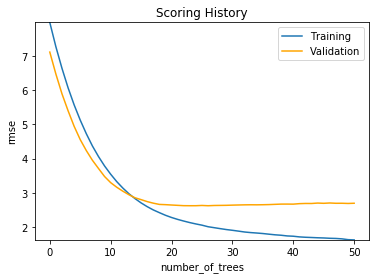

deploying regression
Table exists. Dropping table
Saving artifact of size: 37.898 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:25:22.501 - A service worker has found your request
INFO     2020-11-25 21:25:22.543 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:25:22.576 - Handler is available
INFO     2020-11-25 21:25:22.600 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:25:22.702 - Retrieved MLFlow Run
INFO     2020-11-25 21:25:22.724 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:25:22.769 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:25:22.787 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:25:22.815 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:25:22.841 - Decompressing Model Ar

In [22]:
cars = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/junit/cars_20mpg.csv")
cars.rename(columns={'year':'year_make'})
r = cars[0].runif()
train = cars[r > .2]
valid = cars[r <= .2]
response_col = "economy"
distribution = "gaussian"
predictors = ["displacement","power","weight","acceleration","year_make"]
model = H2OGradientBoostingEstimator(nfolds=3,
                                   distribution=distribution,
                                   fold_assignment="Random")
model.train(x=predictors,
          y=response_col,
          training_frame=train,
          validation_frame=valid)
model.plot(timestep="AUTO", metric="AUTO",)


print('deploying regression')
splice.dropTableIfExists(f'{schema}.h2o_regression')

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_regression',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

In [23]:
%%sql

insert into h2o_regression (displacement,power,weight,acceleration,year_make, moment_key) values(18,101,22,23.142,1,1 );
insert into h2o_regression (displacement,power,weight,acceleration,year_make, moment_key) values(18,6,232,100,3,2);

select * from h2o_regression;

select displacement,power,weight,acceleration,year_make,prediction into ${data_and_preds} from h2o_regression;

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [31]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['DISPLACEMENT','POWER','WEIGHT','ACCELERATION','YEAR_MAKE']])
db_preds = data[['PREDICTION']]
features.columns = [i.lower() for i in features.columns]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)


for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    db_p = db_pred[1]['PREDICTION']
    raw_p = raw_pred[1]['predict']
    
    l = min(16, len(str(db_p)), len(str(raw_p))) -2 # -2 because of the decimal point and final value
    assert round(db_p,l) == round(raw_p,l), f'Something is wrong. Model Table gives {db_p} but raw model gives {raw_p}'

print('test passed!')

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
test passed!


## HGLM Model example

In [32]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
cars = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/junit/cars_20mpg.csv")
cars.rename(columns={'year':'year_make'})
r = cars[0].runif()
train = cars[r > .2]
valid = cars[r <= .2]
response = "economy"
distribution = "gaussian"
predictors = ["displacement","power","weight","acceleration","year_make"]
model = H2OGeneralizedLinearEstimator(alpha=.25)
model.train(x=predictors,
                 y=response,
                 training_frame=train,
                 validation_frame=valid)


print('deploying hglm')
splice.dropTableIfExists(f'{schema}.h2o_hglm')

while mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_hglm',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
deploying hglm
Saving artifact of size: 5.801 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:27:45.551 - A service worker has found your request
INFO     2020-11-25 21:27:45.592 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:27:45.626 - Handler is available
INFO     2020-11-25 21:27:45.647 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:27:45.710 - Retrieved MLFlow Run
INFO     2020-11-25 21:27:45.733 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:27:45.782 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:27:45.804 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:27:45.834 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:27:45.861 - Decompressing Model Ar

In [33]:
%%sql

insert into h2o_hglm (displacement,power,weight,acceleration,year_make, moment_key) values(18,101,22,23.142,1,1 );
insert into h2o_hglm (displacement,power,weight,acceleration,year_make, moment_key) values(18,6,232,100,3,2);

select * from h2o_hglm;

select displacement,power,weight,acceleration,year_make,prediction into ${data_and_preds} from h2o_hglm;

In [34]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['DISPLACEMENT','POWER','WEIGHT','ACCELERATION','YEAR_MAKE']])
db_preds = data[['PREDICTION']]
features.columns = [i.lower() for i in features.columns]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)


for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    db_p = db_pred[1]['PREDICTION']
    raw_p = raw_pred[1]['predict']
    
    l = min(16, len(str(db_p)), len(str(raw_p))) -2
    assert round(db_p,l) == round(raw_p,l), f'Something is wrong. Model Table gives {db_p} but raw model gives {raw_p}'

print('test passed!')

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
test passed!


## Word2Vec example

In [35]:
from h2o.estimators.word2vec import H2OWord2vecEstimator
job_titles_path = "https://raw.githubusercontent.com/h2oai/sparkling-water/rel-1.6/examples/smalldata/craigslistJobTitles.csv"
job_titles = h2o.import_file(job_titles_path, destination_frame = "jobtitles",
                             col_names = ["category", "jobtitle"], col_types = ["enum", "string"], header = 1)
STOP_WORDS = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what",
               "there","all","we","one","the","a","an","of","or","in","for","by","on",
               "but","is","in","a","not","with","as","was","if","they","are","this","and","it","have",
               "from","at","my","be","by","not","that","to","from","com","org","like","likes","so"]

def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words


words = tokenize(job_titles["jobtitle"])
words.columns = ['word']

print("Build word2vec model")
model = H2OWord2vecEstimator(sent_sample_rate = 0.0, epochs = 10, vec_size=15)
model.train(training_frame=words)


print("Sanity check - find synonyms for the word 'teacher'")
model.find_synonyms("teacher", count = 5)

print('deploying w2v')
splice.dropTableIfExists(f'{schema}.h2o_w2v')

while mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_w2v',mlflow.current_run_id(), df=hc.asSparkFrame(words), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Build word2vec model
word2vec Model Build progress: |██████████████████████████████████████████| 100%
Sanity check - find synonyms for the word 'teacher'
deploying w2v
Saving artifact of size: 103.279 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:28:20.546 - A service worker has found your request
INFO     2020-11-25 21:28:20.583 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:28:20.620 - Handler is available
INFO     2020-11-25 21:28:20.640 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:28:20.700 - Retrieved MLFlow Run
INFO     2020-11-25 21:28:20.720 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:28:20.763 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:28:20.781 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:28:20.809 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:28:20.835 - Decompressing Model Ar

In [36]:
%%sql
insert into h2o_w2v (word, moment_key) values('teacher', 1);
insert into h2o_w2v (word, moment_key) values('teachers', 2);
insert into h2o_w2v (word, moment_key) values('elementary', 3);

select * from h2o_w2v;
select * into ${data_and_preds} from h2o_w2v;

In [37]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['WORD']])
db_preds = data[['word_C0','word_C1','word_C2','word_C3','word_C4','word_C5','word_C6','word_C7','word_C8','word_C9','word_C10','word_C11','word_C12','word_C13','word_C14']]
features.columns = [i.lower() for i in features.columns]

raw_preds = model.transform(features,aggregate_method=None).as_data_frame(use_pandas=True)


for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
#     db_p, db_c0, db_c1, db_c2, db_c3, db_c4 = db_pred[1]
#     raw_p, raw_c0, raw_c1, raw_c2, raw_c3, raw_c4 = raw_pred[1]
    # Table returns string but h2o returns int index
    for db, raw in zip(db_pred[1], raw_pred[1]):
        assert round(db,14) == round(raw,14), f'Something is wrong. Model Table gives {db} but raw model gives {raw}'

print('test passed!')

Parse progress: |█████████████████████████████████████████████████████████| 100%
test passed!


## AutoEncoder Example

In [38]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
# train = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/mnist/train.csv.gz")
# test = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/mnist/test.csv.gz")

import random
train = []
test = []
for i in range(60000):
    train.append([random.random()*4 for i in range(6)])
    test.append([random.random()*4 for i in range(6)])

train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)
predictors = [f'C{i}' for i in range(1,7)]


model = H2OAutoEncoderEstimator(activation="Tanh",
                                   hidden=[2],
                                   l1=1e-5,
                                   ignore_const_cols=False,
                                   epochs=1)
model.train(x=predictors,training_frame=train)
test_rec_error = model.anomaly(test)
test_rec_error
test_rec_error_features = model.anomaly(test, per_feature=True)
print(test_rec_error_features)
model.predict(test)

print('deploying autoencoder')
splice.dropTableIfExists(f'{schema}.h2o_ae')

while mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_ae',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


reconstr_C1.SE,reconstr_C2.SE,reconstr_C3.SE,reconstr_C4.SE,reconstr_C5.SE,reconstr_C6.SE
0.0968696,0.00186831,0.0236483,0.316328,0.0154392,0.072383
0.0900991,0.144147,0.0244125,0.163053,0.113798,0.0200023
0.00655416,0.22751,0.169456,0.00301388,0.12906,0.0128973
0.0041591,5.21e-07,0.0187153,0.00118691,0.0201489,0.0358883
0.00434698,0.0863694,0.132245,0.0833289,0.0622806,0.127037
0.0231179,0.235324,0.218086,0.00134694,0.187245,0.0499606
0.0227876,0.067962,0.0901349,0.129349,0.00521986,0.00191159
0.00639448,0.126894,4.2368e-05,0.00666487,0.000802673,0.170669
0.0154813,0.0236197,0.0515209,0.0939627,0.00230567,0.00104477
0.000706211,0.109755,0.169829,0.0557486,0.0671676,0.120217



deeplearning prediction progress: |███████████████████████████████████████| 100%
deploying autoencoder
Saving artifact of size: 7.679 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:28:38.848 - A service worker has found your request
INFO     2020-11-25 21:28:38.880 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:28:38.914 - Handler is available
INFO     2020-11-25 21:28:38.934 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:28:39.007 - Retrieved MLFlow Run
INFO     2020-11-25 21:28:39.025 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:28:39.066 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:28:39.083 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:28:39.108 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:28:39.130 - Decompressing Model Ar

In [39]:
%%sql

insert into h2o_ae (moment_key,c1,c2,c3,c4,c5,c6) values(1,0, 0, 0, 0, 0, 0);
insert into h2o_ae (moment_key,c1,c2,c3,c4,c5,c6) values(2,1, 1, 1, 1, 1, 1);
insert into h2o_ae (moment_key,c1,c2,c3,c4,c5,c6) values(3,0.25, 0.99, 0.623, 0.21, 0.52, 0.66);

select * from h2o_ae;
select * into ${data_and_preds} from h2o_ae;

In [40]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['C1','C2','C3','C4','C5','C6']])
db_preds = data[['C1_reconstr','C2_reconstr','C3_reconstr','C4_reconstr','C5_reconstr','C6_reconstr']]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)


for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    # Check reconstruction values
    for db, raw in zip(db_pred[1], raw_pred[1]):
        assert round(db,13) == round(raw,13), f'Something is wrong. Model Table gives {db} but raw model gives {raw}'

# Check the MSE score
raw_mses = model.anomaly(features).as_data_frame(use_pandas=True)
db_mses = data[['MSE_reconstr']]
for db_mse, raw_mse in zip(db_mses.iterrows(), raw_mses.iterrows()):
    # Check reconstruction values
    for db, raw in zip(db_pred[1], raw_pred[1]):
        assert round(db,13) == round(raw,13), f'Something is wrong. Model Table gives {db} but raw model gives {raw}'
    
print('test passed!')

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
test passed!


## Clustering

In [41]:
from h2o.estimators.kmeans import H2OKMeansEstimator
import random

train = []
test = []
for i in range(60000):
    train.append([random.random()*4 for i in range(6)])
    test.append([random.random()*4 for i in range(6)])

train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)
predictors = [f'C{i}' for i in range(1,7)]


model = H2OKMeansEstimator(k=3, nfolds=3)
model.train(x=list(range(4)), training_frame=train)


print('deploying clustering')
splice.dropTableIfExists(f'{schema}.h2o_cluster')

while mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_cluster',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
deploying clustering
Saving artifact of size: 6.557 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:28:55.181 - A service worker has found your request
INFO     2020-11-25 21:28:55.215 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:28:55.244 - Handler is available
INFO     2020-11-25 21:28:55.264 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:28:55.329 - Retrieved MLFlow Run
INFO     2020-11-25 21:28:55.349 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:28:55.396 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:28:55.417 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:28:55.444 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:28:55.470 - Decompressing Model Ar

In [57]:
mlflow.download_artifact('model','/tmp/downloaded_model.zip','ce35a49c5441')

In [58]:
!unzip /tmp/downloaded_model.zip

Archive:  /tmp/downloaded_model.zip
replace MLmodel? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [64]:
!ls /tmp/downloaded_model/model.h2o/KMeans_model_python_1606338895375_628

/tmp/downloaded_model/model.h2o/KMeans_model_python_1606338895375_628


In [72]:
h2o.upload_model('/tmp/downloaded_model/model.h2o')

IsADirectoryError: [Errno 21] Is a directory: '/tmp/downloaded_model/model.h2o'

In [74]:
x = mlflow.pyfunc.load_model('/tmp/downloaded_model')

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,29 mins 29 secs
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,8 days
H2O_cluster_name:,sparkling-water-jovyan_spark-application-1606338834225
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.718 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


H2OResponseError: Server error water.exceptions.H2OIllegalArgumentException:
  Error: Illegal argument: dir of function: importModel: water.api.FSIOException: FS IO Failure: 
 accessed path : file:/tmp/downloaded_model/model.h2o/KMeans_model_python_1606338895375_628 msg: File not found
  Request: POST /99/Models.bin/
    data: {'dir': '/tmp/downloaded_model/model.h2o/KMeans_model_python_1606338895375_628'}


In [60]:
mlflow.h2o.load_model('file:///tmp/downloaded_model')

H2OResponseError: Server error water.exceptions.H2OIllegalArgumentException:
  Error: Illegal argument: dir of function: importModel: water.api.FSIOException: FS IO Failure: 
 accessed path : file:/tmp/downloaded_model/model.h2o/KMeans_model_python_1606338895375_628 msg: File not found
  Request: POST /99/Models.bin/
    data: {'dir': '/tmp/downloaded_model/model.h2o/KMeans_model_python_1606338895375_628'}


In [75]:
%%sql

insert into h2o_cluster (moment_key,c1,c2,c3,c4,c5,c6) values(1,0, 0, 0, 0, 0, 0);
insert into h2o_cluster (moment_key,c1,c2,c3,c4,c5,c6) values(2,0.258682,2.03961,3.13087,2.71747,2.46077,0.24339);
insert into h2o_cluster (moment_key,c1,c2,c3,c4,c5,c6) values(3,0.25, 0.99, 0.623, 0.21, 0.52, 0.66);

select * from h2o_cluster;
select * into ${data_and_preds} from h2o_cluster;

In [76]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['C1','C2','C3','C4','C5','C6']])
db_preds = data[['PREDICTION']]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)


for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    # Check reconstruction values
    for db, raw in zip(db_pred[1], raw_pred[1]):
        assert round(db,13) == round(raw,13), f'Something is wrong. Model Table gives {db} but raw model gives {raw}'

    
print('test passed!')

test passed!


## PCA Example

In [77]:
from h2o.estimators import H2OPrincipalComponentAnalysisEstimator

train = []
test = []
for i in range(60000):
    train.append([random.random()*4 for i in range(6)])
    test.append([random.random()*4 for i in range(6)])

train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)
predictors = [f'C{i}' for i in range(1,7)]

model = H2OPrincipalComponentAnalysisEstimator(k = 4, transform = "STANDARDIZE", pca_method="Power",
                   use_all_factor_levels=True, impute_missing=True)
model.train(x=train.names, training_frame=train)


print('deploying pca')
splice.dropTableIfExists(f'{schema}.h2o_pca')

while mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_pca',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

_train: PCA Power method failed to converge within TOLERANCE.  Increase max_iterations or reduce TOLERANCE to mitigate this problem.


deploying pca
Saving artifact of size: 52.228 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:55:35.328 - A service worker has found your request
INFO     2020-11-25 21:55:35.370 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:55:35.404 - Handler is available
INFO     2020-11-25 21:55:35.426 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:55:35.494 - Retrieved MLFlow Run
INFO     2020-11-25 21:55:35.513 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:55:35.561 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:55:35.580 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:55:35.610 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:55:35.636 - Decompressing Model Ar

In [78]:
%%sql

insert into h2o_pca (moment_key,c1,c2,c3,c4,c5,c6) values(1,0, 0, 0, 0, 0, 0);
insert into h2o_pca (moment_key,c1,c2,c3,c4,c5,c6) values(2,0.258682,2.03961,3.13087,2.71747,2.46077,0.24339);
insert into h2o_pca (moment_key,c1,c2,c3,c4,c5,c6) values(3,0.25, 0.99, 0.623, 0.21, 0.52, 0.66);

select * from h2o_pca;
select * into ${data_and_preds} from h2o_pca;

In [79]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['C1','C2','C3','C4','C5','C6']])
db_preds = data[['PC0','PC1','PC2','PC3']]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)


for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    # Check reconstruction values
    for db, raw in zip(db_pred[1], raw_pred[1]):
        assert round(db,13) == round(raw,13), f'Something is wrong. Model Table gives {db} but raw model gives {raw}'

    
print('test passed!')

test passed!


## Isolation Forest Example

In [80]:
cars = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/junit/cars_20mpg.csv")
cars.rename(columns={'year':'year_make'})
predictors = ["displacement","power","weight","acceleration","year_make"]
model = H2OIsolationForestEstimator(seed=1234,score_each_iteration=True,score_tree_interval=5)
model.train(x=predictors,
              training_frame=cars)
model.model_performance()


print('deploying isoforect')
splice.dropTableIfExists(f'{schema}.h2o_iso')

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_iso',mlflow.current_run_id(), df=hc.asSparkFrame(cars).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

Stopping tolerance is ignored for _stopping_rounds=0.


deploying isoforect
Saving artifact of size: 89.908 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:55:44.972 - A service worker has found your request
INFO     2020-11-25 21:55:45.004 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:55:45.034 - Handler is available
INFO     2020-11-25 21:55:45.052 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:55:45.110 - Retrieved MLFlow Run
INFO     2020-11-25 21:55:45.127 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:55:45.168 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:55:45.185 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:55:45.212 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:55:45.237 - Decompressing Model Ar

In [81]:
%%sql

insert into h2o_iso (displacement,power,weight,acceleration,year_make, moment_key) values(18,101,22,23.142,1,1 );
insert into h2o_iso (displacement,power,weight,acceleration,year_make, moment_key) values(18,6,232,100,3,2);

select * from h2o_iso;

select displacement,power,weight,acceleration,year_make, "normalizedScore","score" into ${data_and_preds} from h2o_iso;

In [82]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['DISPLACEMENT','POWER','WEIGHT','ACCELERATION','YEAR_MAKE']])
db_preds = data[['normalizedScore','score']]
features.columns = [i.lower() for i in features.columns]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)

for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    # Check reconstruction values
    for db, raw in zip(db_pred[1], raw_pred[1]):
        assert round(db,13) == round(raw,13), f'Something is wrong. Model Table gives {db} but raw model gives {raw}'

print('test passed!')

test passed!


## Neural Network

In [83]:
cars = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/junit/cars_20mpg.csv")
cars.rename(columns={'year':'year_make'})
cars["cylinders"] = cars["cylinders"].asfactor()
r = cars[0].runif()
train = cars[r > .2]
valid = cars[r <= .2]
response_col = "cylinders"

predictors = ["displacement","power","weight","acceleration","year_make"]



model = H2ODeepLearningEstimator(variable_importances=True,loss ="Automatic")

model.train(x                =predictors,
              y                =response_col,
               training_frame  =train,
              validation_frame=valid)



print('deploying neural network')
splice.dropTableIfExists(f'{schema}.h2o_nn')

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_nn',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)


deploying neural network
Saving artifact of size: 483.271 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:55:57.366 - A service worker has found your request
INFO     2020-11-25 21:55:57.402 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:55:57.431 - Handler is available
INFO     2020-11-25 21:55:57.448 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:55:57.510 - Retrieved MLFlow Run
INFO     2020-11-25 21:55:57.527 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:55:57.565 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:55:57.583 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:55:57.609 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:55:57.640 - Decompressing Model Ar

In [84]:
%%sql

insert into h2o_nn (displacement,power,weight,acceleration,year_make, moment_key) values(18,101,22,23.142,1,1 );
insert into h2o_nn (displacement,power,weight,acceleration,year_make, moment_key) values(18,6,232,100,3,2);

select * from h2o_nn;

select displacement,power,weight,acceleration,year_make,prediction, c3,c4,c5,c6,c8 into ${data_and_preds} from h2o_nn;

In [85]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['DISPLACEMENT','POWER','WEIGHT','ACCELERATION','YEAR_MAKE']])
db_preds = data[['PREDICTION','C3','C4','C5','C6','C8']]
features.columns = [i.lower() for i in features.columns]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)


for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    # Check reconstruction values
    for db, raw in zip(db_pred[1], raw_pred[1]):
        if isinstance(db,str):
            raw = f'C{int(raw)}'
            assert db==raw, f'Something is wrong. Model Table gives {db} but raw model gives {raw}'
        else:
            assert round(db,13) == round(raw,13), f'Something is wrong. Model Table gives {db} but raw model gives {raw}'

    
print('test passed!')

test passed!


## XGBoost

In [5]:
import h2o
from h2o.estimators import H2OXGBoostEstimator

# Import the titanic dataset into H2O:
titanic = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/titanic.csv")

# Set the predictors and response; set the response as a factor:
titanic["survived"] = titanic["survived"].asfactor()
predictors = ['sibsp', 'sex', 'age']
response = "survived"

# Split the dataset into a train and valid set:
train, valid = titanic.split_frame(ratios=[.8], seed=1234)

# Build and train the model:
model = H2OXGBoostEstimator(booster='dart',
                                  normalize_type="tree",
                                  seed=1234)
model.train(x=predictors,
                  y=response,
                  training_frame=train,
                  validation_frame=valid)

# Eval performance:
perf = model.model_performance()

# Generate predictions on a test set (if necessary):
pred = model.predict(valid)

print('deploying xgb')
splice.dropTableIfExists('splice.h2o_xgb')

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db('splice','h2o_xgb',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
deploying xgb
Table exists. Dropping table
Saving artifact of size: 55.564 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 22:03:32.544 - A service worker has found your request
INFO     2020-11-25 22:03:32.578 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 22:03:32.608 - Handler is available
INFO     2020-11-25 22:03:32.631 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 22:03:32.694 - Retrieved MLFlow Run
INFO     2020-11-25 22:03:32.712 - Updating MLFlow Run for the UI
INFO     2020-11-25 22:03:32.753 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 22:03:32.772 - Extracting Model from DB with Name: model
INFO     2020-11-25 22:03:32.798 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 22:03:32.823 - Decompressing Model Ar

In [6]:
%%sql
insert into splice.h2o_xgb (moment_key,sibsp,sex,age) values(0, 5,'female',2.496);
insert into splice.h2o_xgb (moment_key,sibsp,sex,age) values(1, 1,'male',-7.048);
select * from h2o_xgb;
select sibsp, sex, age, prediction, c0, c1 into ${data_and_preds} from splice.h2o_xgb;

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Sql started successfully



In [9]:
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['SIBSP','SEX','AGE']])
db_preds = data[['PREDICTION','C0','C1']]
features.columns = [i.lower() for i in features.columns]

raw_preds = model.predict(features).as_data_frame(use_pandas=True)



for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    db_p, db_c0, db_c1 = db_pred[1]
    raw_p, raw_c0, raw_c1 = raw_pred[1]
    # Table returns string but h2o returns int index
    raw_p = f'C{int(raw_p)}'
    
    assert db_p == raw_p, f'Something is wrong. Model Table gives {db_p} but raw model gives {raw_p}'
    assert round(db_c0,14) == round(raw_c0,14), f'Something is wrong. Model Table gives {db_c0} but raw model gives {raw_c0}'
    assert round(db_c1,14) == round(raw_c1,14), f'Something is wrong. Model Table gives {db_c1} but raw model gives {raw_c1}'

print('test passed!')

Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
test passed!


In [46]:
spark.stop()

# ===================================== Below is Broken =====================================

## GLRM (not broken but can't test), TargetEncoder (broken on deploy)

### GLRM explanation https://0xdata.atlassian.net/browse/PUBDEV-7761

## GLRM

In [86]:
train = []
test = []
for i in range(60000):
    train.append([random.random()*4 for i in range(6)])

train = h2o.H2OFrame(train)
predictors = [f'C{i}' for i in range(1,7)]

model = H2OGeneralizedLowRankEstimator(k=6,seed=1234, impute_original=True,transform='Normalize')
model.train(x=predictors, training_frame=train)

print('deploying glrm')
splice.dropTableIfExists(f'{schema}.h2o_glrm')

while mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db(schema,'h2o_glrm',mlflow.current_run_id(), df=hc.asSparkFrame(train).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

deploying glrm
Saving artifact of size: 2790.735 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 21:56:21.612 - A service worker has found your request
INFO     2020-11-25 21:56:21.643 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 21:56:21.671 - Handler is available
INFO     2020-11-25 21:56:21.689 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 21:56:21.752 - Retrieved MLFlow Run
INFO     2020-11-25 21:56:21.769 - Updating MLFlow Run for the UI
INFO     2020-11-25 21:56:21.812 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 21:56:21.833 - Extracting Model from DB with Name: model
INFO     2020-11-25 21:56:21.870 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 21:56:21.968 - Decompressing Model Ar

In [102]:

model.reconstruct(h2o.H2OFrame([[0,0,0,0,0,0]]))
# dir(model)

reconstr_C1,reconstr_C2,reconstr_C3,reconstr_C4,reconstr_C5,reconstr_C6
-0.499772,-0.501924,-0.500133,-0.49943,-0.499896,-0.499611


In [87]:
%%sql
truncate table h2o_glrm;
insert into h2o_glrm (moment_key,c1,c2,c3,c4,c5,c6) values(1,0, 0, 0, 0, 0, 0);
insert into h2o_glrm (moment_key,c1,c2,c3,c4,c5,c6) values(2,0.258682,2.03961,3.13087,2.71747,2.46077,0.24339);
insert into h2o_glrm (moment_key,c1,c2,c3,c4,c5,c6) values(3,0.25, 0.99, 0.623, 0.21, 0.52, 0.66);

select * from h2o_glrm;
select * into ${data_and_preds} from h2o_glrm;

# NOTE
## GLRM Can act as both autoencoders in that they reconstruct data, and also perform PCA. In the database, we always do PCA (maybe something to change later)
## For reconstruction, you call predict. I don't know how to get components

In [191]:
from beakerx.object import beakerx
data = beakerx.get('data_and_preds')

features = h2o.H2OFrame(data[['C1','C2','C3','C4','C5','C6']])
db_preds = data[['PC0','PC1','PC2','PC3','PC4','PC5']]

# GLRM Can act as both autoencoders in that they reconstruct data, and also perform PCA. In the database, we always do PCA (maybe something to change later)
# To get the PCA, you call proj_archetypes, for reconstruction, you call predict
raw_preds = model.proj_archetypes(features).as_data_frame(use_pandas=True)


for db_pred, raw_pred in zip(db_preds.iterrows(), raw_preds.iterrows()):
    # Check reconstruction values
    for db, raw in zip(db_pred[1], raw_pred[1]):
        assert round(db,13) == round(raw,13), f'Something is wrong. Model Table gives {db} but raw model gives {raw}'

print('test passed!')

Parse progress: |█████████████████████████████████████████████████████████| 100%


AssertionError: Something is wrong. Model Table gives 0.001523829447429341 but raw model gives -3.414778858782197

### GLRM is weird because it can act as either Dim Reduction or an Autoencoder... Which should we pick?

In [266]:
pca_path = model.download_mojo('/tmp/gbm.zip')


from py4j.java_gateway import java_import
java_import(splice.jvm, 'hex.genmodel.easy.EasyPredictModelWrapper')
java_import(splice.jvm, 'hex.genmodel.MojoModel')
java_import(splice.jvm, 'java.io.ByteArrayOutputStream')
java_import(splice.jvm, 'java.io.ObjectOutputStream') 
java_import(splice.jvm, 'hex.genmodel.easy.RowData')
java_import(splice.jvm, 'hex.genmodel.easy.prediction.DimReductionModelPrediction')


java_mojo_c = splice.jvm.EasyPredictModelWrapper.Config().setModel(splice.jvm.MojoModel.load(pca_path))
java_mojo = splice.jvm.EasyPredictModelWrapper(java_mojo_c)



m = splice.jvm.MojoModel.load(pca_path)

# java_mojo.predictDimReduction(train)


print(java_mojo.getModelCategory().toString())


row = splice.jvm.RowData()
row.put("C1", "0")
row.put("C2", "0")
row.put("C3", "0")
row.put("C4", "0")
row.put("C5", "0")
row.put("C6", "0")

d = splice.jvm.DimReductionModelPrediction

# pred = m.predictDimReduction(row)

# list(java_mojo.predictDimReduction(row))

DimReduction


In [45]:
from splicemachine.notebook import hide_toggle
hide_toggle(toggle_next=True)

In [179]:
%%java
%classpath add jar db-client-3.0.0.1950.jar
%classpath add jar /home/jovyan/nn_model.jar
import java.sql.*; 
import java.util.*; 
import hex.genmodel.easy.RowData;
import hex.genmodel.easy.EasyPredictModelWrapper;
import hex.genmodel.easy.prediction.*;
import java.io.*;
import hex.genmodel.MojoModel;
import hex.genmodel.InMemoryMojoReaderBackend;
import java.sql.Driver;  
import com.splicemachine.db.jdbc.*;


Driver d = new com.splicemachine.db.jdbc.ClientDriver();  
DriverManager.registerDriver(d);
Connection conn = DriverManager.getConnection("jdbc:splice://jdbc-test-aks-dev1.dev.splicemachine-dev.io:1527/splicedb;ssl=basic","splice","admin");
PreparedStatement pstmt = conn.prepareStatement("select \"binary\" from mlmanager.artifacts where RUN_UUID=? and NAME=?");
        pstmt.setString(1, "6ba390856894");
        pstmt.setString(2,"h2omojo");
        ResultSet rs = pstmt.executeQuery();
        EasyPredictModelWrapper model = null;
        if(rs.next()) {
            Blob blobModel = rs.getBlob(1);
            InputStream bis = blobModel.getBinaryStream();
            ObjectInputStream ois = new ObjectInputStream(bis);
            model = (EasyPredictModelWrapper) (ois.readObject());
            ois.close();
        }

        

RowData row = new RowData();

row.put("SDSS_J", "000009.26+151754.5");
row.put("R.A.", "9.08519705868309");
row.put("Dec.", "4.932083187033184");
row.put("z", "7.139249327431729");
row.put("u_mag", "7.139249327431729");
row.put("sig_u", "7.139249327431729");
row.put("g_mag", "7.139249327431729");
row.put("sig_g", "7.139249327431729");
row.put("r_mag", "7.139249327431729");
row.put("sig_r", "7.139249327431729");
row.put("i_mag", "7.139249327431729");
row.put("sig_i", "7.139249327431729");
row.put("z_mag", "7.139249327431729");
row.put("sig_z", "7.139249327431729");
row.put("Radio", "7.139249327431729");
row.put("X-ray", "7.139249327431729");
row.put("J_mag", "7.139249327431729");
row.put("sig_J", "7.139249327431729");
row.put("H_mag", "7.139249327431729");
row.put("sig_H", "7.139249327431729");
row.put("K_mag", "7.139249327431729");
row.put("sig_K", "7.139249327431729");
row.put("M_i", "7.139249327431729");


AbstractPrediction p;
p = model.predictDimReduction(row);

final StringBuilder builder = new StringBuilder();
//for(int i = 0; i < classProbs.length; i++){
//    builder.append(i).append("=").append(classProbs[i]).append(";");
//}
//return builder.substring(0, builder.length() - 1);
//return c;

final double[] dim = ((DimReductionModelPrediction) p).dimensions;
//AutoEncoderModelPrediction


//for(int i = 0; i < dim.length; i++){
//    builder.append("PC" + i).append("=").append(Double.toString(dim[i])).append(";");
//}

return dim;
//return builder.substring(0, builder.length() - 1);

Java started successfully



Bad classpath, file not found
Bad classpath, file not found


package hex.genmodel.easy does not exist: package hex.genmodel.easy does not exist

## TargetEncoder (BROKEN on Deploy)

In [10]:
titanic = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/titanic.csv")
titanic.rename(columns={'home.dest':'home_dest'})
predictors = ["home_dest", "cabin", "embarked"]
response = "survived"
titanic["survived"] = titanic["survived"].asfactor()
fold_col = "kfold_column"
titanic[fold_col] = titanic.kfold_column(n_folds=5, seed=1234)
model = H2OTargetEncoderEstimator(k=35,
                                       f=25,
                                       blending=True)
model.train(x=predictors,
                 y=response,
                 training_frame=titanic)


print('deploying target encoder')
splice.dropTableIfExists('splice.te')

with mlflow.start_run():
    mlflow.log_model(model, 'model')
    jid = mlflow.deploy_db('splice','te',mlflow.current_run_id(), df=hc.asSparkFrame(titanic).select(predictors), create_model_table=True, primary_key=[('MOMENT_KEY','INTEGER')])
    mlflow.watch_job(jid)

Parse progress: |█████████████████████████████████████████████████████████| 100%


``k`` is deprecated, please use ``inflection_point`` instead.
``f`` is deprecated, please use ``smoothing`` instead.


targetencoder Model Build progress: |█████████████████████████████████████| 100%
deploying target encoder
Saving artifact of size: 8.535 KB to Splice Machine DB
Deploying model to database...


Passing in primary keys as a list of tuples is deprecated. Use dictionary {column name: type}


Your Job has been submitted. The returned value of this function is the job id, which you can use to monitor the your task in real-time. Run mlflow.watch_job(<job id>) tostream them to stdout, or mlflow.fetch_logs(<job id>) to read them one time to a list

---Job Logs---
INFO     2020-11-25 22:05:42.296 - A service worker has found your request
INFO     2020-11-25 22:05:42.334 - Checking whether handler DEPLOY_DATABASE is enabled
INFO     2020-11-25 22:05:42.369 - Handler is available
INFO     2020-11-25 22:05:42.393 - Retrieving Run from MLFlow Tracking Server...
INFO     2020-11-25 22:05:42.464 - Retrieved MLFlow Run
INFO     2020-11-25 22:05:42.484 - Updating MLFlow Run for the UI
INFO     2020-11-25 22:05:42.536 - Reading Model Artifact Stream from Splice Machine
INFO     2020-11-25 22:05:42.557 - Extracting Model from DB with Name: model
INFO     2020-11-25 22:05:42.589 - Decoding Model Artifact Binary Stream for Deployment
INFO     2020-11-25 22:05:42.614 - Decompressing Model Ar

In [ ]:
%%sql

insert into h2o_nn (displacement,power,weight,acceleration,year_make, moment_key) values(18,101,22,23.142,1,1 );
insert into h2o_nn (displacement,power,weight,acceleration,year_make, moment_key) values(18,6,232,100,3,2);

select * from h2o_nn;

select displacement,power,weight,acceleration,year_make,prediction, c3,c4,c5,c6,c8 into ${data_and_preds} from h2o_nn;